# [Tensorflow - Help Protect the Great Barrier Reef](https://www.kaggle.com/c/tensorflow-great-barrier-reef)
> Detect crown-of-thorns starfish in underwater image data

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/31703/logos/header.png?t=2021-10-29-00-30-04">

## 📒 Notebooks:
* Train: [Great-Barrier-Reef: YOLOv5 [train] 🌊](https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-train)
* Infer: [Great-Barrier-Reef: YOLOv5 [infer] 🌊](https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-infer)

# 🚩 Version Info
| Version | Model | Conf | IoU | LB  | Comment
|---|---|---|---|---|---|
| v25 | YOLOv5s | 0.15 | 0.50 | 0.453 |  |
| v30 | YOLOv5s | 0.19 | 0.45 | 0.433 | tta |


# 🛠 Install Libraries

In [1]:
# !pip install -q imagesize
# !pip install -qU wandb
# !add-apt-repository ppa:ubuntu-toolchain-r/test -y
# !apt-get update
# !apt-get upgrade libstdc++6 -y

# 📚 Import Libraries

In [2]:
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob
import shutil
import sys
sys.path.append('../input/tensorflow-great-barrier-reef')
import torch
from PIL import Image
import ast

# 📌 Key-Points
* One have to submit prediction using the provided **python time-series API**, which makes this competition different from previous Object Detection Competitions.
* Each prediction row needs to include all bounding boxes for the image. Submission is format seems also **COCO** which means `[x_min, y_min, width, height]`
* Copmetition metric `F2` tolerates some false positives(FP) in order to ensure very few starfish are missed. Which means tackling **false negatives(FN)** is more important than false positives(FP). 
$$F2 = 5 \cdot \frac{precision \cdot recall}{4\cdot precision + recall}$$

## Please Upvote if you find this Helpful

# 📖 Meta Data
* `train_images/` - Folder containing training set photos of the form `video_{video_id}/{video_frame}.jpg`.

* `[train/test].csv` - Metadata for the images. As with other test files, most of the test metadata data is only available to your notebook upon submission. Just the first few rows available for download.

* `video_id` - ID number of the video the image was part of. The video ids are not meaningfully ordered.
* `video_frame` - The frame number of the image within the video. Expect to see occasional gaps in the frame number from when the diver surfaced.
* `sequence` - ID of a gap-free subset of a given video. The sequence ids are not meaningfully ordered.
* `sequence_frame` - The frame number within a given sequence.
* `image_id` - ID code for the image, in the format `{video_id}-{video_frame}`
* `annotations` - The bounding boxes of any starfish detections in a string format that can be evaluated directly with Python. Does not use the same format as the predictions you will submit. Not available in test.csv. A bounding box is described by the pixel coordinate `(x_min, y_min)` of its lower left corner within the image together with its `width` and `height` in pixels --> (COCO format).

In [3]:
ROOT_DIR  = '/kaggle/input/tensorflow-great-barrier-reef/'
CKPT_PATH = '/kaggle/input/reefyolov5/l_43.pt'
IMG_SIZE  = 3600
CONF      = 0.15
IOU       = 0.50
AUGMENT   = False

In [4]:
def get_path(row):
    row['image_path'] = f'{ROOT_DIR}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row

In [5]:
# Train Data
df = pd.read_csv(f'{ROOT_DIR}/train.csv')
df = df.progress_apply(get_path, axis=1)
df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))
display(df.head(2))

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   

                                          image_path  
0  /kaggle/input/tensorflow-great-barrier-reef//t...  
1  /kaggle/input/tensorflow-great-barrier-reef//t...

## Number of BBoxes

In [6]:
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts()/len(df)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

  0%|          | 0/23501 [00:00<?, ?it/s]

No BBox: 79.07% | With BBox: 20.93%


# 🔨 Helper

In [7]:
def voc2yolo(bboxes, image_height=720, image_width=1280):
    """
    voc  => [x1, y1, x2, y1]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]/ image_height
    
    w = bboxes[..., 2] - bboxes[..., 0]
    h = bboxes[..., 3] - bboxes[..., 1]
    
    bboxes[..., 0] = bboxes[..., 0] + w/2
    bboxes[..., 1] = bboxes[..., 1] + h/2
    bboxes[..., 2] = w
    bboxes[..., 3] = h
    
    return bboxes

def yolo2voc(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

def coco2yolo(bboxes, image_height=720, image_width=1280):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

def yolo2coco(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes

def voc2coco(bboxes, image_height=720, image_width=1280):
    bboxes  = voc2yolo(bboxes, image_height, image_width)
    bboxes  = yolo2coco(bboxes, image_height, image_width)
    return bboxes


def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)


def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

def draw_bboxes(img, bboxes, classes, class_ids, colors = None, show_classes = None, bbox_format = 'yolo', class_name = False, line_thickness = 2):  
     
    image = img.copy()
    show_classes = classes if show_classes is None else show_classes
    colors = (0, 255 ,0) if colors is None else colors
    
    if bbox_format == 'yolo':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:
            
                x1 = round(float(bbox[0])*image.shape[1])
                y1 = round(float(bbox[1])*image.shape[0])
                w  = round(float(bbox[2])*image.shape[1]/2) #w/2 
                h  = round(float(bbox[3])*image.shape[0]/2)

                voc_bbox = (x1-w, y1-h, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(get_label(cls)),
                             line_thickness = line_thickness)
            
    elif bbox_format == 'coco':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:            
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                w  = int(round(bbox[2]))
                h  = int(round(bbox[3]))

                voc_bbox = (x1, y1, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)

    elif bbox_format == 'voc_pascal':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes: 
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                x2 = int(round(bbox[2]))
                y2 = int(round(bbox[3]))
                voc_bbox = (x1, y1, x2, y2)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)
    else:
        raise ValueError('wrong bbox format')

    return image

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

# 📦 [YOLOv5](https://github.com/ultralytics/yolov5/)
<img src="https://github.com/ultralytics/yolov5/releases/download/v1.0/splash.jpg" width=800>

In [8]:
!mkdir -p /root/.config/Ultralytics
!cp /kaggle/input/yolov5-font/Arial.ttf /root/.config/Ultralytics/

In [9]:
def load_model(ckpt_path, conf=0.25, iou=0.50):
    model = torch.hub.load('/kaggle/input/yolov5-lib-ds',
                           'custom',
                           path=ckpt_path,
                           source='local',
                           force_reload=True)  # local repo
    model.conf = conf  # NMS confidence threshold
    model.iou  = iou  # NMS IoU threshold
    model.classes = None   # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 1000  # maximum number of detections per image
    return model

# 🔭 Inference

## Helper

In [10]:
def predict(model, img, size=768, augment=False):
    height, width = img.shape[:2]
    results = model(img, size=size, augment=augment)  # custom inference size
    preds   = results.pandas().xyxy[0]
    bboxes  = preds[['xmin','ymin','xmax','ymax']].values
    if len(bboxes):
        bboxes  = voc2coco(bboxes,height,width).astype(int)
        confs   = preds.confidence.values
        return bboxes, confs
    else:
        return [],[]
    
def format_prediction(bboxes, confs):
    annot = ''
    if len(bboxes)>0:
        for idx in range(len(bboxes)):
            xmin, ymin, w, h = bboxes[idx]
            conf             = confs[idx]
            annot += f'{conf} {xmin} {ymin} {w} {h}'
            annot +=' '
        annot = annot.strip(' ')
    return annot

def show_img(img, bboxes, bbox_format='yolo'):
    names  = ['starfish']*len(bboxes)
    labels = [0]*len(bboxes)
    img    = draw_bboxes(img = img,
                           bboxes = bboxes, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = bbox_format,
                           line_thickness = 2)
    return Image.fromarray(img).resize((800, 400))

## Run Inference on **Train**

YOLOv5 🚀 2022-1-18 torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 367 layers, 46108278 parameters, 0 gradients
Adding AutoShape... 


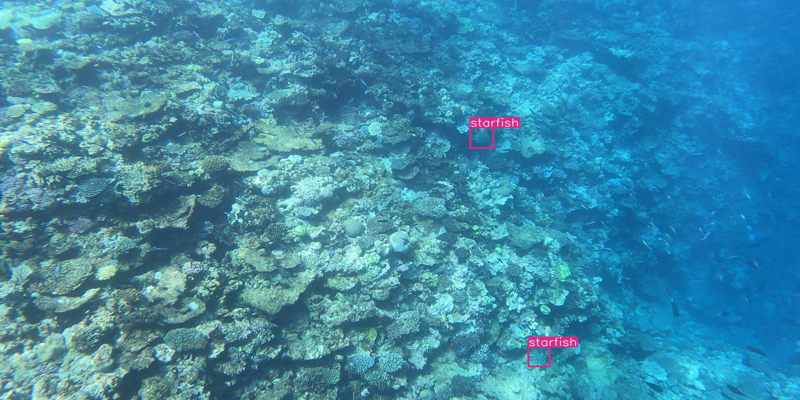

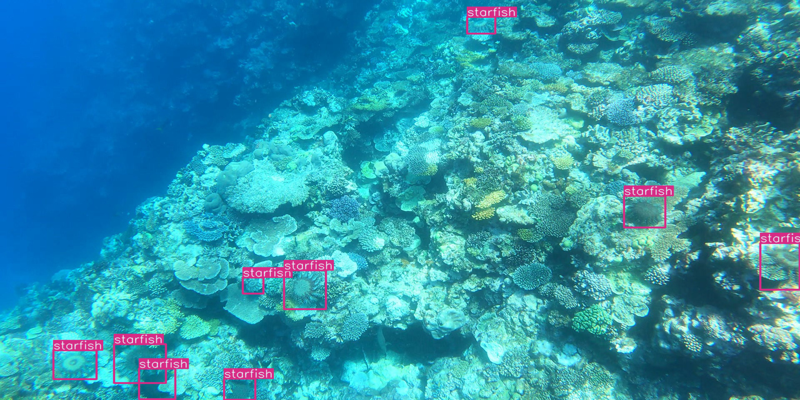

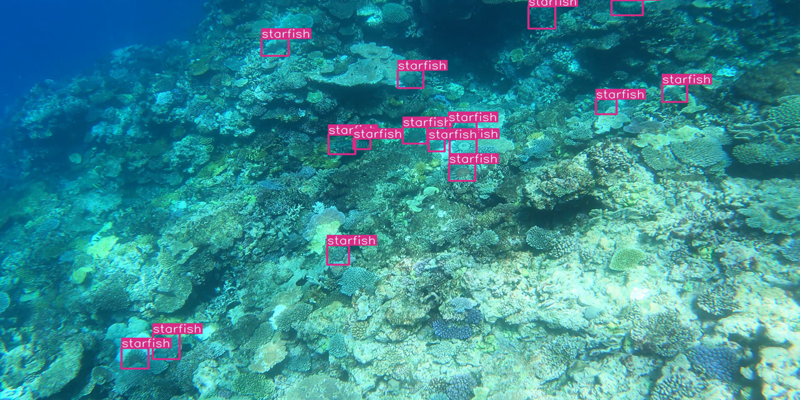

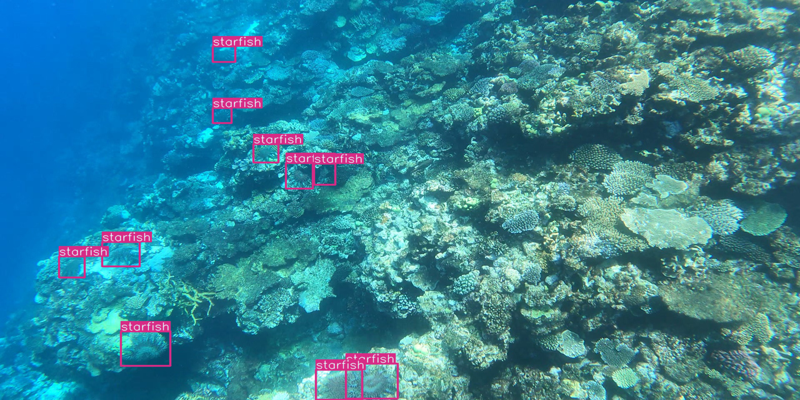

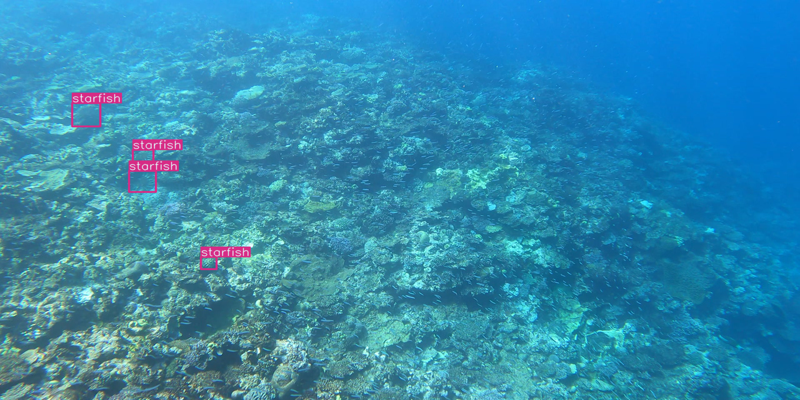

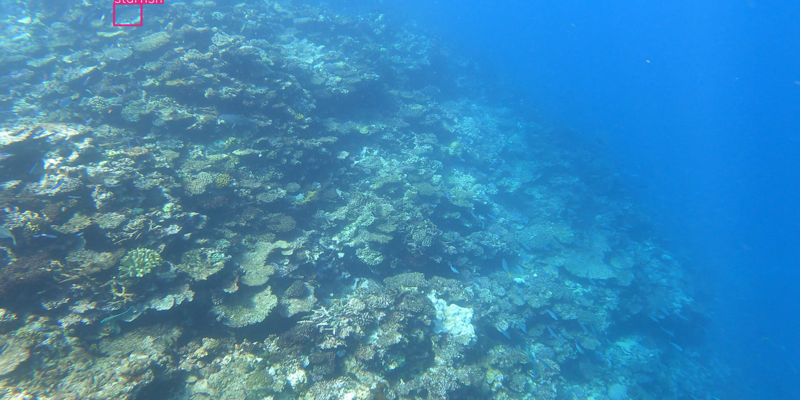

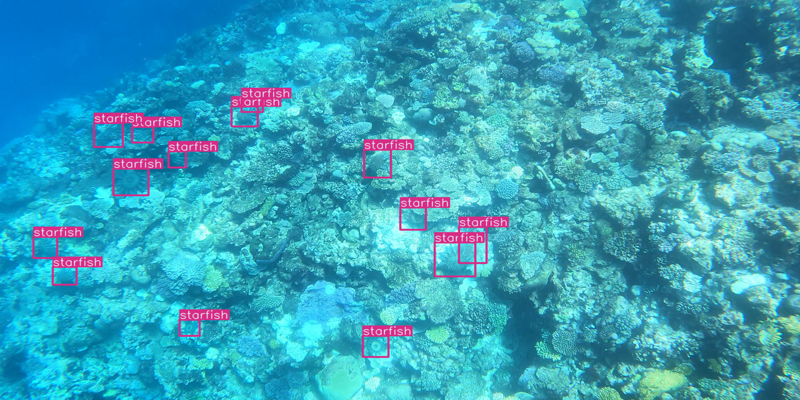

In [11]:
model = load_model(CKPT_PATH, conf=CONF, iou=IOU)
image_paths = df[df.num_bbox>1].sample(100).image_path.tolist()
for idx, path in enumerate(image_paths):
    img = cv2.imread(path)[...,::-1]
    bboxes, confis = predict(model, img, size=IMG_SIZE, augment=AUGMENT)
    display(show_img(img, bboxes, bbox_format='coco'))
    if idx>5:
        break

## Init `Env`

In [12]:
import greatbarrierreef
env = greatbarrierreef.make_env()# initialize the environment
iter_test = env.iter_test()      # an iterator which loops over the test set and sample submission

## Run Inference on **Test**

YOLOv5 🚀 2022-1-18 torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 367 layers, 46108278 parameters, 0 gradients
Adding AutoShape... 


0it [00:00, ?it/s]

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


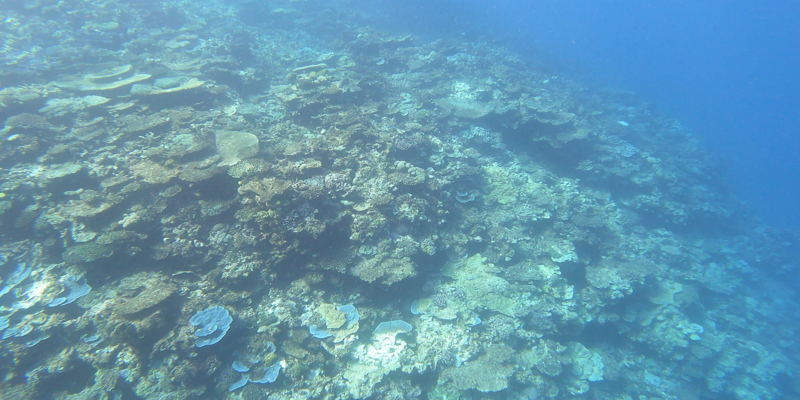

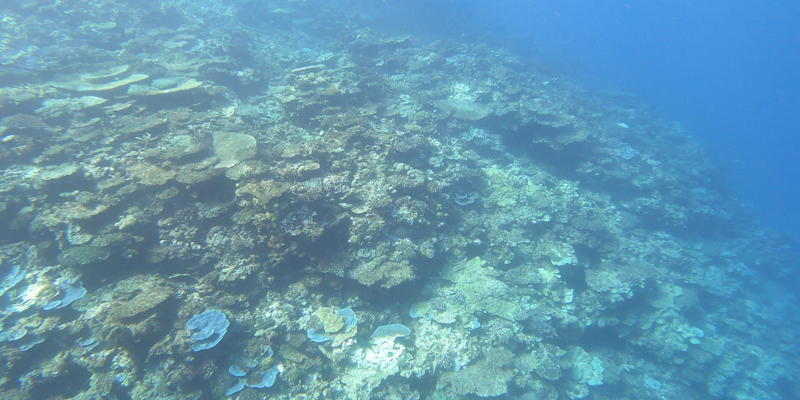

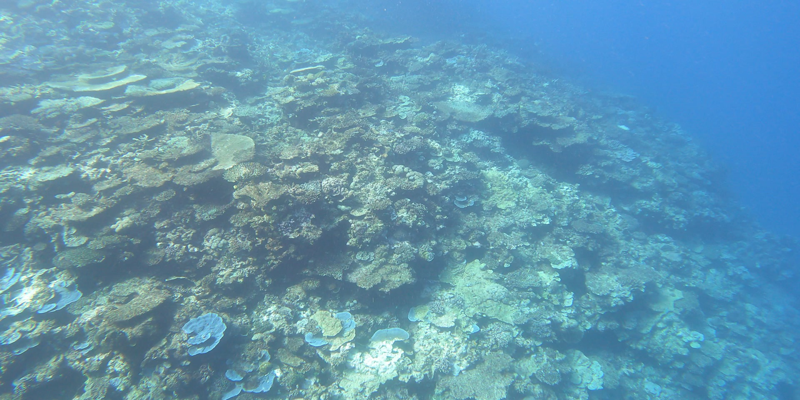

In [13]:
model = load_model(CKPT_PATH, conf=CONF, iou=IOU)
for idx, (img, pred_df) in enumerate(tqdm(iter_test)):
    bboxes, confs  = predict(model, img, size=IMG_SIZE, augment=AUGMENT)
    annot          = format_prediction(bboxes, confs)
    pred_df['annotations'] = annot
    env.predict(pred_df)
    if idx<3:
        display(show_img(img, bboxes, bbox_format='coco'))

# 👀 Check Submission

In [14]:
sub_df = pd.read_csv('submission.csv')
sub_df.head()

index  annotations
0      0          NaN
1      1          NaN
2      2          NaN

## Please Upvote if you find this Helpful

<img src="https://www.pngall.com/wp-content/uploads/2018/04/Under-Construction-PNG-File.png">